# CH4 Time Series Modeling
**Objective**: Develop a SARIMA model for forecasting atmospheric methane concentration

## Input Data
'data/processed/all_ghg_aligned_nan.csv'

## Stages
1. train/test split
2. test data transformations (differencing and log) and perform residuals analyses
3. Auto-ARIMA parameter search
4. TimeSeriesSplit CV parameter search on out-of-sample performance
5. Residuals analyses on best models
6. SARIMA model selection

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox 
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white, het_arch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import time

from src.preprocessing import GasPreprocessor
from src.model_evaluation import in_sample_resid_analysis
from src.model_evaluation import out_of_sample_residual_analysis, summarize_model_assumptions
print('GasPreprocessor imported successfully!')
print('in_sample_resid_analysis imported successfully!')
print('out_of_sample_residual_analysis imported successfully!')
print('summarize_model_assumptions imported successfully!')

GasPreprocessor imported successfully!
in_sample_resid_analysis imported successfully!
out_of_sample_residual_analysis imported successfully!
summarize_model_assumptions imported successfully!


# Load the Data

In [3]:
df_combined = pd.read_csv('../data/processed/all_ghg_aligned_nan.csv',
                          parse_dates=['date'], index_col='date')

In [4]:
df_combined['CH4'].head()

date
1969-08-20   NaN
1969-08-27   NaN
1969-09-02   NaN
1969-09-12   NaN
1969-09-24   NaN
Name: CH4, dtype: float64

In [5]:
df_combined['CH4'].tail(10)

date
2024-12-24    1952.380
2024-12-31    1977.445
2025-01-03         NaN
2025-01-07         NaN
2025-01-14         NaN
2025-01-21         NaN
2025-01-29         NaN
2025-02-11         NaN
2025-02-25         NaN
2025-04-03         NaN
Name: CH4, dtype: float64

In [6]:
# determine the first and last valid index for the CH4 series.  
# Note: df_combined is a concatenated and pivoted dataframe of 6 greenhouse gases that were aligned based on 
# data collection date.  So, there will certainly be missing values at the beginning of 5 of the 6 gas data series.  

print("First CH4 data point:", df_combined['CH4'].first_valid_index())
print("Last CH4 data point:", df_combined['CH4'].last_valid_index())
print("\nInitial gap duration:", df_combined['CH4'].first_valid_index() - df_combined['CH4'].index[0])
print("End gap duration:", df_combined['CH4'].index[-1] - df_combined['CH4'].last_valid_index())

First CH4 data point: 1983-05-06 00:00:00
Last CH4 data point: 2024-12-31 00:00:00

Initial gap duration: 5007 days 00:00:00
End gap duration: 93 days 00:00:00


**NOTE:** The GasPreprocessor class has methods to trim the initial and trailing NaNs.  However, an accurate train/test split is more dependent on trailing NaNs since they would be further trimmed during preprocessed by the GasPreprocessor class resulting in a smaller test set than expected.  So, I will trim the trailing NaNs prior to train/test split.  

# Split the Data Into Training and Testing Sets

## Trim Trailing NaNs

As observed in the notebook 2_all_gas_eda.ipynb, the missing data heatmap revealed that, in addition to NaNs prior to the first valid index (first data collection date) for CH4, there are also NaNs at the end of the series.

In [7]:
# Trim trailing NaNs prior to train/test split

def trim_trailing_nans(series):
    '''
    Trim trailing NaN values from a series.
    '''
    last_valid_idx = series.last_valid_index()
    if last_valid_idx is not None and last_valid_idx < series.index[-1]:
        print(f'Trimming {len(series.loc[last_valid_idx:]) - 1} trailing NaN values from the raw series')
        return series.loc[:last_valid_idx]
    return series

In [8]:
# create CH4 series with trimmed trailing NaNs

ch4_clean = trim_trailing_nans(df_combined['CH4'])
ch4_clean_df = ch4_clean.reset_index() # convert back to DataFrame with date column

print(f'CH4 raw data: {len(df_combined['CH4'])} points, from {df_combined['CH4'].index.min()} to {df_combined['CH4'].index.max()}')
print(f'CH4 raw data trimmed of trailing NaNs: {len(ch4_clean)} points, from {ch4_clean.index.min()} to {ch4_clean.index.max()}')

Trimming 8 trailing NaN values from the raw series
CH4 raw data: 2562 points, from 1969-08-20 00:00:00 to 2025-04-03 00:00:00
CH4 raw data trimmed of trailing NaNs: 2554 points, from 1969-08-20 00:00:00 to 2024-12-31 00:00:00


## Split the Data and Inspect

In [9]:
test_size = 52 # one year of weekly data

CH4_train = ch4_clean.iloc[:-test_size]
CH4_test = ch4_clean.iloc[-test_size:]

print(f'Train data: {CH4_train.shape[0]} data points, from {CH4_train.index.min()} to {CH4_train.index.max()}')
print(f'Test data: {CH4_test.shape[0]} data points, from {CH4_test.index.min()} to {CH4_test.index.max()}')

Train data: 2502 data points, from 1969-08-20 00:00:00 to 2023-10-17 00:00:00
Test data: 52 data points, from 2023-10-24 00:00:00 to 2024-12-31 00:00:00


In [10]:
CH4_train.head()

date
1969-08-20   NaN
1969-08-27   NaN
1969-09-02   NaN
1969-09-12   NaN
1969-09-24   NaN
Name: CH4, dtype: float64

In [11]:
# Check the last training point vs first test point
print('Last training date:', CH4_train.index[-1])
print('First test date:', CH4_test.index[0])
print('\nGap between train end and test start:', CH4_test.index[0] - CH4_train.index[-1])

Last training date: 2023-10-17 00:00:00
First test date: 2023-10-24 00:00:00

Gap between train end and test start: 7 days 00:00:00


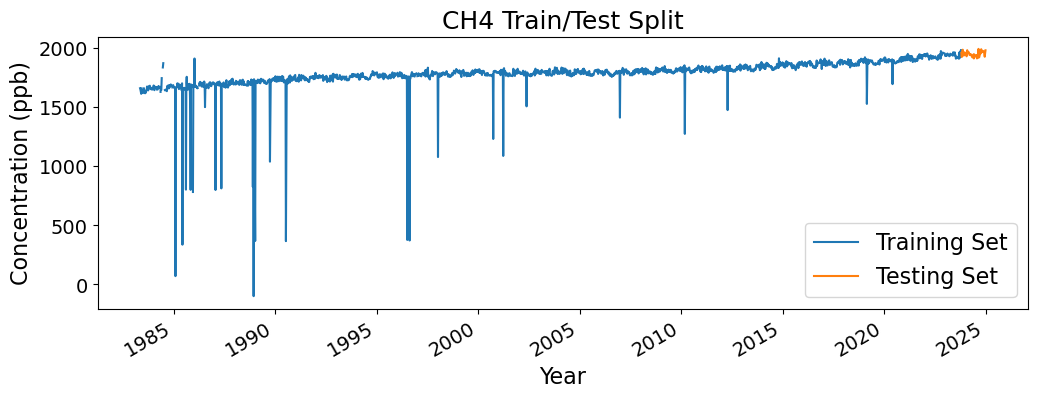

In [12]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,4))
CH4_train.plot(ax=ax, label='Training Set')
CH4_test.plot(ax=ax, label='Testing Set')

ax.legend(fontsize=16)
ax.set_title('CH4 Train/Test Split', fontsize=18)
ax.set_ylabel('Concentration (ppb)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

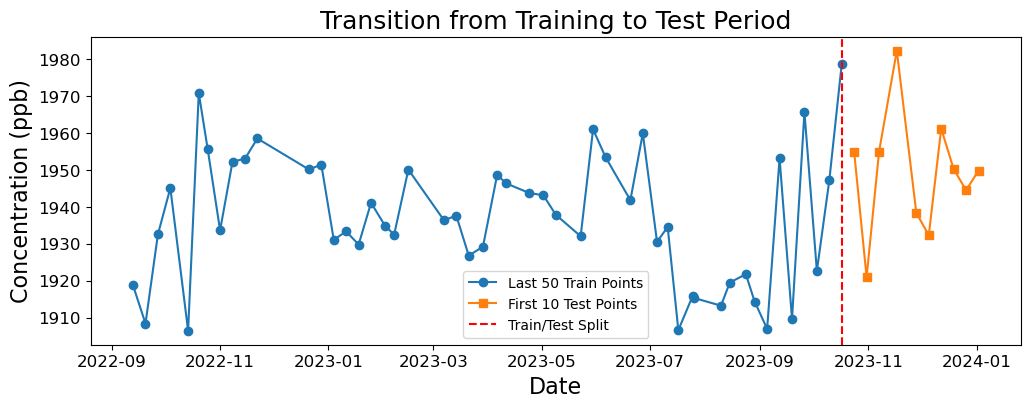

In [13]:
# Plot the transition from train to test

plt.figure(figsize=(12,4))
plt.plot(CH4_train.index[-50:], CH4_train.values[-50:], 
         label='Last 50 Train Points', marker='o')
plt.plot(CH4_test.index[:10], CH4_test.values[:10],
         label='First 10 Test Points', marker='s')
plt.axvline(x=CH4_train.index[-1], color='red', linestyle='--', 
            label='Train/Test Split')
plt.legend()
plt.title('Transition from Training to Test Period', fontsize=18)
plt.ylabel('Concentration (ppb)', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

## Proprocessing and EDA of CH4 Train Set

### Convert Train and Test Sets to DataFrame for preprocessor

In [14]:
CH4_train_df = CH4_train.reset_index().rename(columns={'index' : 'date', 0 : 'CH4'})
CH4_test_df = CH4_test.reset_index().rename(columns={'index' : 'date', 0 : 'CH4'})

In [15]:
CH4_train_df.head()

,date,CH4
0,1969-08-20,NaN
1,1969-08-27,NaN
2,1969-09-02,NaN
3,1969-09-12,NaN
4,1969-09-24,NaN


In [16]:
CH4_test_df.head()

,date,CH4
0,2023-10-24,1954.8800
1,2023-10-31,1920.9425
2,2023-11-07,1954.9450
3,2023-11-17,1982.3325
4,2023-11-28,1938.3800


In [17]:
# Check the last training point vs first test point after restoring the date column, etc

print('Last training date:', CH4_train_df['date'].iloc[-1])
print('First test date:', CH4_test_df['date'].iloc[0])
print('\nGap between train end and test start:', CH4_test_df['date'].iloc[0] - CH4_train_df['date'].iloc[-1])

Last training date: 2023-10-17 00:00:00
First test date: 2023-10-24 00:00:00

Gap between train end and test start: 7 days 00:00:00



[INFO] Fitting preprocessing for CH4

Trimming 388 leading NaN values
Raw data: 2502 points, 431 NaNs
Trimmed data: 2114 points, 43 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
After resampling: 2112 points, 67 NaNs
[INFO] Found 150 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 217 NaNs
After smoothing: 2112 points, 1 NaNs
After interpolation: 2112 points, 0 NaNs


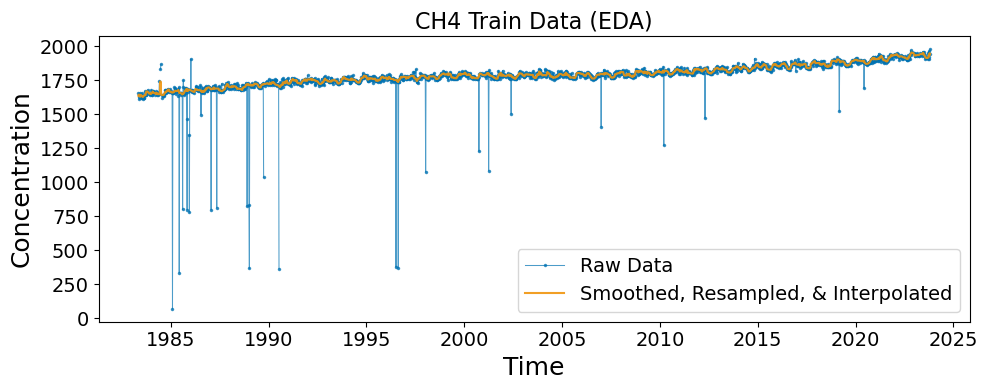

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -1.0139
ADF p-value 0.7481
ADF critical values: {'1%': -3.433479704613104, '5%': -2.8629225683793083, '10%': -2.5675060146913125}

KPSS statistic 6.6953
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


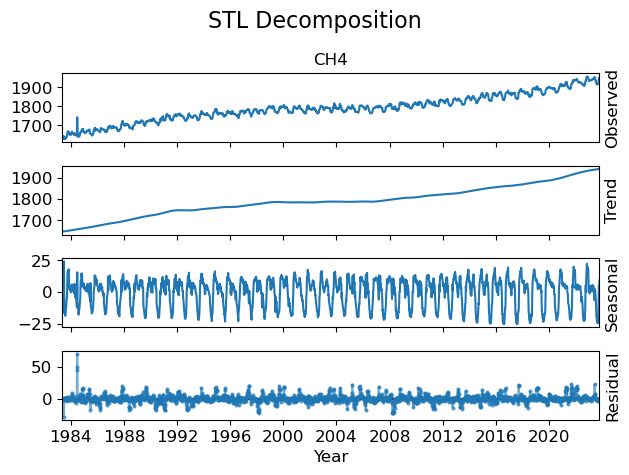

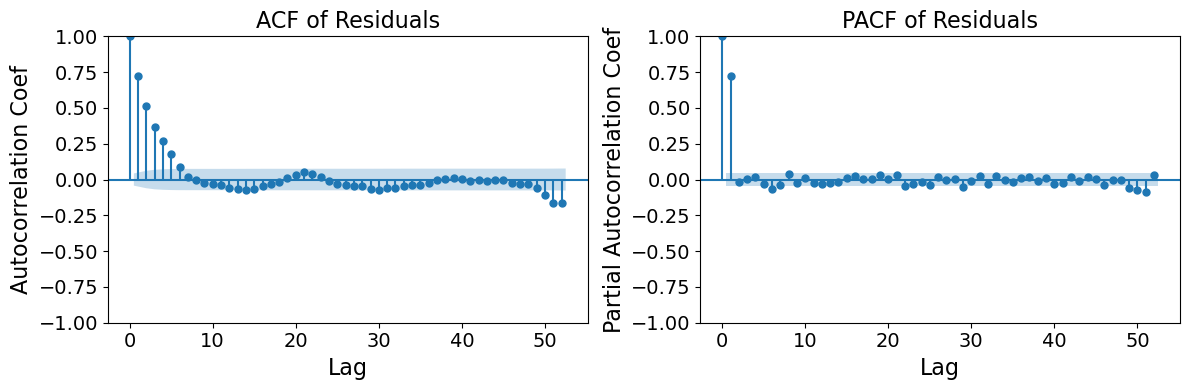


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0196
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0028
Heteroscedasticity detected (White test)

Trimming 388 leading NaN values
Adjusting test set dates to be contiguous with train set


In [18]:
# fit and transform the training data to the GasPreprocessor class
# transform the test data using the fitted preprocessor

CH4_train_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True)
CH4_train_preprocessed = CH4_train_preprocessor.fit_transform(
    CH4_train_df, 
    custom_title = 'CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_preprocessed = CH4_train_preprocessor.transform(CH4_test_df)

**Interpretation of the CH4 train series preprocessing and EDA**

Preprocessing the CH4 data appears to be effectively handling negative values, NaNs, and outliers while preserving the seasonality and trend.  The ADF and KPSS tests confirm that the data series is not stationary.  

STL decomposition provides visual confirmation of the positive trend and the regular, annual seasonality of atomospheric CH4 concentration.  The residuals are analyzed with the ACF and PACF plots.  

The ACF plot has significant spikes at lags 1-5 (not including the first lag (lag 0)) and oscillating behavior.  This suggests that autocorrelation exists in the training set after preprocessing.  Also notable are the significance of lags around 52 indicating seasonal autocorrelation.  

The gradual tapering down of significan lags in the ACF plot and the sharp cut off after lag 1 in the PACF plot suggest an AR(p) model, possibly AR(1).  

The ADF and KPSS results show that the residuals confirm that the data series is non-stationary, supporting the observation of a positive trend.  Non-seasonal differencing may be necessary.  

Heteroscedasticity - both the Breusch-Pagan and White tests indicate heteroscedasticity in the CH4 train set residuals.  So, log or Box-Cox transformation will likely be necessary.  

In [19]:
print('CH4_train shape:', CH4_train_df.shape)
print('CH4_test shape:', CH4_test_df.shape)

print('CH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)
CH4_train_preprocessed shape: (2112,)
CH4_test_preprocessed shape: (63,)


The difference in numbers of observations is due to resampling (performed by the Preprocessor class).  

the lengths of the split datasets after preprocessing, specifically due to weekly resampling, reflect their actual time spans, not just the number of data points:

- Train: 2111 weeks (2111 weeks / 52 weeks/year = 40.6 years)
- Test: 62 weeks (62 weeks / 52 weeks/year = 1.2 years)
- The sum of weeks = 2173, which is 41.8 years. The full CH4 data series spans 1983-2025, which is ~42 years.

In [20]:
# Check the last training point vs first test point after preprocessed both series. 

print('Last train_preprocessed date:', CH4_train_preprocessed.index[-1])
print('First test_preprocessed date:', CH4_test_preprocessed.index[0])
print('\nGap between train end and test start:', CH4_test_preprocessed.index[0] - CH4_train_preprocessed.index[-1])

Last train_preprocessed date: 2023-10-22 00:00:00
First test_preprocessed date: 2023-10-29 00:00:00

Gap between train end and test start: 7 days 00:00:00


# Save the Preprocessed Train and Test data

In [21]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [22]:
# save the preprocessed train data
output_path = output_dir / 'CH4_train_preprocessed.csv'
(
    CH4_train_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data
output_path = output_dir / 'CH4_test_preprocessed.csv'
(
    CH4_test_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_train_preprocessed.shape}')
print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_test_preprocessed.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (2112,)

CH4_test_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (63,)


# Preprocessing With Log Transformation


[INFO] Fitting preprocessing for CH4

Trimming 388 leading NaN values
Raw data: 2502 points, 431 NaNs
Trimmed data: 2114 points, 43 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
[INFO] Applying log transformation.
After resampling: 2112 points, 67 NaNs
[INFO] Found 148 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 215 NaNs
After smoothing: 2112 points, 0 NaNs
After interpolation: 2112 points, 0 NaNs


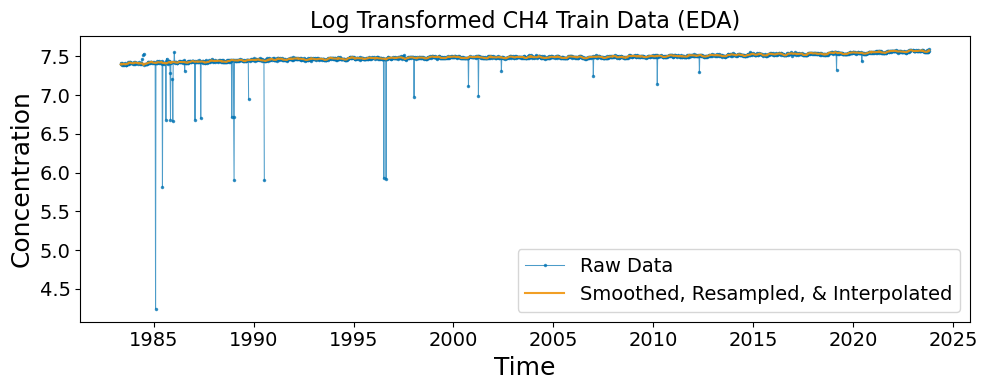

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.9846
ADF p-value 0.7588
ADF critical values: {'1%': -3.433481203206757, '5%': -2.862923230045995, '10%': -2.5675063669901363}

KPSS statistic 6.6824
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


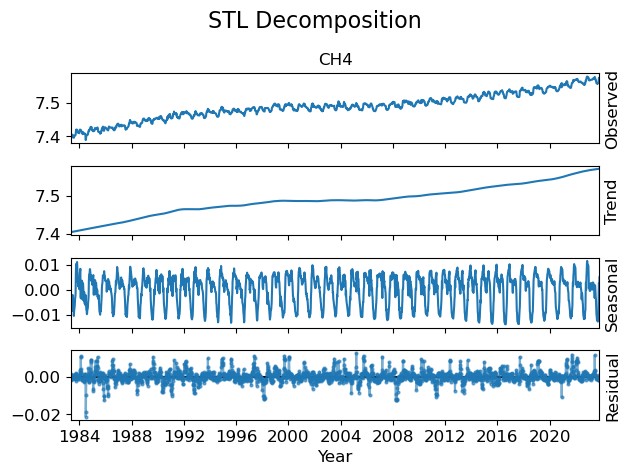

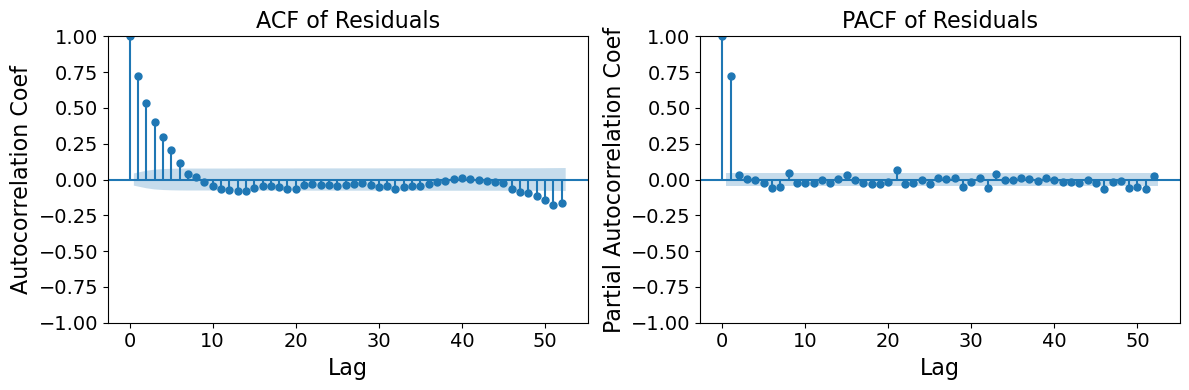


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0126
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0241
Heteroscedasticity detected (White test)

Trimming 388 leading NaN values
Adjusting test set dates to be contiguous with train set


In [23]:
# fit and transform the training data to the GasPreprocessor class, including log transformation to handle heteroscedasticity
# transform the validation and test data using the fitted preprocessor

CH4_train_log_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True, transformation='log')
CH4_train_log_preprocessed = CH4_train_log_preprocessor.fit_transform(
    CH4_train_df, 
    custom_title = 'Log Transformed CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_log_preprocessed = CH4_train_log_preprocessor.transform(CH4_test_df)

In [24]:
# verify data structure following transformation and preprocessing 

print('CH4_train shape:', CH4_train_df.shape)
print('CH4_test shape:', CH4_test_df.shape)

print('\nCH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

print('\nCH4_train_log_preprocessed shape:', CH4_train_log_preprocessed.shape)
print('CH4_test_log_preprocessed shape:', CH4_test_log_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)

CH4_train_preprocessed shape: (2112,)
CH4_test_preprocessed shape: (63,)

CH4_train_log_preprocessed shape: (2112,)
CH4_test_log_preprocessed shape: (63,)


In [25]:
# Check the last training point vs first test point after log and preprocessing both series. 

print('Last train_log_preprocessed date:', CH4_train_log_preprocessed.index[-1])
print('First test_log_preprocessed date:', CH4_test_log_preprocessed.index[0])
print('Gap between train end and test start:', CH4_test_log_preprocessed.index[0] - CH4_train_log_preprocessed.index[-1])

# Check for any NaN values that might cause issues
print(f'\ntrain_log_preprocessed NaN count: {CH4_train_log_preprocessed.isna().sum()}')
print(f'test_log_preprocessed NaN count: {CH4_test_log_preprocessed.isna().sum()}')

# Verify frequency is consistent
print(f'\ntrain_log_preprocessed frequency: {CH4_train_log_preprocessed.index.freq}')
print(f'test_log_preprocessed frequency: {CH4_test_log_preprocessed.index.freq}')

Last train_log_preprocessed date: 2023-10-22 00:00:00
First test_log_preprocessed date: 2023-10-29 00:00:00
Gap between train end and test start: 7 days 00:00:00

train_log_preprocessed NaN count: 0
test_log_preprocessed NaN count: 0

train_log_preprocessed frequency: <Week: weekday=6>
test_log_preprocessed frequency: <Week: weekday=6>


In [26]:
CH4_train_log_preprocessed.head()

date
1983-05-08    7.400810
1983-05-15    7.405599
1983-05-22    7.405599
1983-05-29    7.400810
1983-06-05    7.396486
Freq: W-SUN, Name: CH4, dtype: float64

In [27]:
CH4_test_log_preprocessed.head()

2023-10-29    7.578101
2023-11-05    7.578101
2023-11-12    7.578084
2023-11-19    7.573846
2023-11-26    7.573863
Freq: W-SUN, Name: CH4, dtype: float64

# Save Log and Preprocessed Data for Forecasting

In [28]:
# define path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [29]:
CH4_train_log_preprocessed.name = 'log_ch4'
CH4_train_log_preprocessed.index.name = 'date'

CH4_test_log_preprocessed.name = 'log_ch4'
CH4_test_log_preprocessed.index.name = 'date'

# save the logged CH4 train data
CH4_train_log_preprocessed.to_csv(
    output_dir / 'CH4_train_log_preprocessed.csv', 
    index = True, # keep the datetime index
    header = True,
    float_format='%.5f'
)
print(f'Saved to: {output_dir / "CH4_train_log_preprocessed.csv"}')

# save the logged CH4 test data
CH4_test_log_preprocessed.to_csv(
    output_dir / 'CH4_test_log_preprocessed.csv', 
    index = True, # keep the datetime index
    header = True,
    float_format='%.5f'
)
print(f'Saved to: {output_dir / "CH4_test_log_preprocessed.csv"}')

Saved to: ..\data\processed\CH4_train_log_preprocessed.csv
Saved to: ..\data\processed\CH4_test_log_preprocessed.csv


**Comparison of Statistical Test Results Before and After Log Transformation of the Training Dataseries:**

- Non-transformed data:

    - ADF statistic: -1.0139, p-value: 0.7481

    - KPSS statistic: 6.6953, p-value: 0.0100

    - result:  the preprocessed data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0196

    - White test p-value: 0.0028

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

- Log-transformed data:

    - ADF statisti:c -0.9846, p-value: 0.7588

    - KPSS statistic: 6.6824, p-value: 0.0100

    - result:  the Processed Data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0126

    - White test p-value: 0.0241

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

Trend/Seasonality:

Log transformation did not affect stationarity, which is expected and will be addressed through differencing in the SARIMA model.

Heteroscedasticity

The log transformation helped slightly based on the White test result, but there is remaining variance in the residuals.

Autocorrelation patterns:

Prior to log transformation, the ACF plot of STL decomposition residuals shows an oscillatory behavior, which is greatly reduced after log transformation. This is an argument for log transformation since it simplifies the correlation structure and should help tune the SARIMA model orders.

Interpretation of ACF and PACF plots for SARIMA model orders:

The ACF plot shows a gradual decay in autocorrelation coefficient magnitude from lag 1 - 5 indicating non-stationarity requiring non-seasonal differencing. The strong spike at lag 1 in the PACF plot indicates first order differencing (d = 1). The significant lag at 52 is consistent with annual seasonality with weekly time points and suggests the need for seasonal differencing (D = 1).

The gradual decay of lags 1 - 5 of the ACF plot and sharp cut off after lag 1 on the PACF plot indicates an AR(1) process.

model suggestion (thus far): SARIMA(1,1,0)(0,1,0)52

# Difference Preprocessed/Log Transformed Train Data

Origninal series length: 2112
Non-seasonally differenced series length: 2111

[INFO] Stationarity tests on non-seasonally differenced series:
ADF and KPSS tests for non-seasonally differenced:
ADF statistic -15.3258
ADF p-value 0.0000
ADF critical values: {'1%': -3.4334842047036167, '5%': -2.8629245552811486, '10%': -2.5675070726005353}

KPSS statistic 0.0595
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


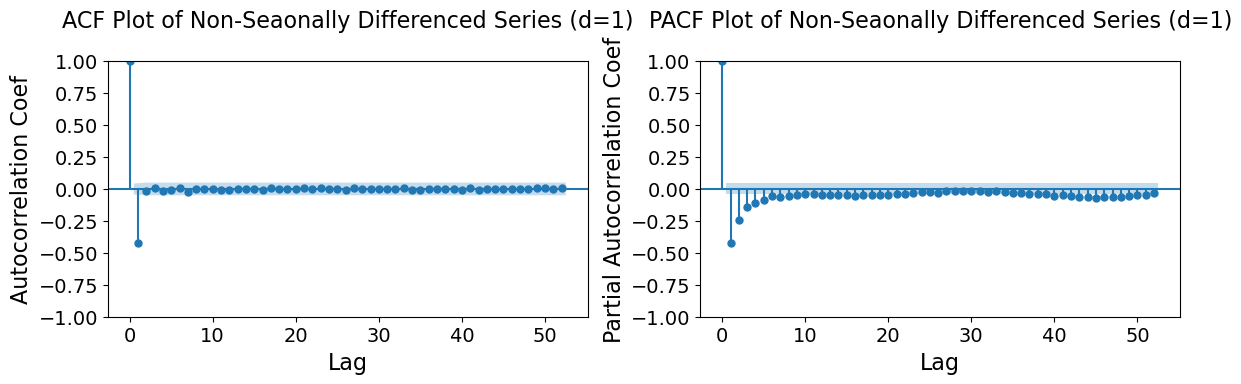

In [30]:
# I will first inspect the residuals of non-seasonally differenced log transformed train data to determine its effectiveness

nsdiffed_series = CH4_train_log_preprocessed.diff(1).dropna()

print(f'Origninal series length: {len(CH4_train_log_preprocessed)}')
print(f'Non-seasonally differenced series length: {len(nsdiffed_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on non-seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced')

# plot ACF and PACF
CH4_train_log_preprocessor.plot_acf_pacf(nsdiffed_series, 'Non-Seaonally Differenced Series (d=1)')

**Interpretation of non-seasonal differencing**

After non-seasonal differencing (d = 1), the log transformed and preprocessed train data is now stationary according to both the ADF and KPSS tests. So, non-seasonal differencing effectively removes the trend.  

ACF and PACF plot results:  The gradual decay seen in the PACF plot along with the sharp cut off observed in the ACF plot indicates a non-seasonal MA(1) process.  


[INFO]: Stationarity tests on seasonally differenced series (D=1 only):
ADF and KPSS tests for seasonally differenced (D=1):
ADF statistic -17.1325
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335345735350664, '5%': -2.862946794168607, '10%': -2.567518913543354}

KPSS statistic 0.3759
KPSS p-value 0.0876
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally differenced (D=1) time series is likely stationary according to ADF and KPSS tests.



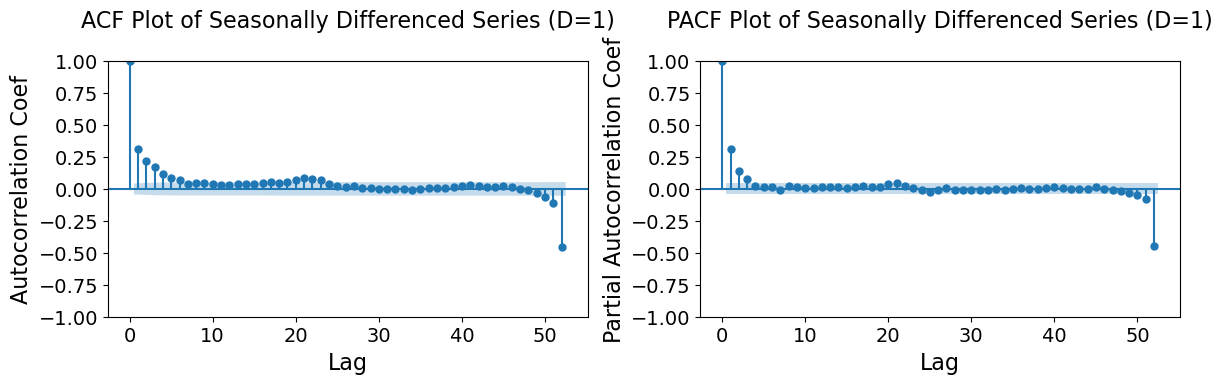

In [31]:
# Test the affect of only seasonal differencing (D=1)

# Apply only seasonal differencing (no non-seasonal)
sdiff = CH4_train_log_preprocessed.diff(52).dropna()

print('\n[INFO]: Stationarity tests on seasonally differenced series (D=1 only):')
CH4_train_log_preprocessor._run_stationarity_tests(sdiff, 'seasonally differenced (D=1)')

# Plot ACF/PACF
CH4_train_log_preprocessor.plot_acf_pacf(sdiff, 'Seasonally Differenced Series (D=1)')

**Interpretation of seasonal differencing**

Seasonal-only differencing also results in a stationary series, suggesting that this differencing removed the seasonality.  The ACF and PACF plots are more complex compared to the non-seasonal-only differencing with gradual decay in both ACF and PACF non-seasonal lags as well as significant spikes at lag 52 (seasonal lag).  


[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:
ADF and KPSS tests for non-seasonally & seasonally differenced:
ADF statistic -16.8519
ADF p-value 0.0000
ADF critical values: {'1%': -3.433564315018763, '5%': -2.862959925476948, '10%': -2.5675259052472796}

KPSS statistic 0.0460
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally & seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


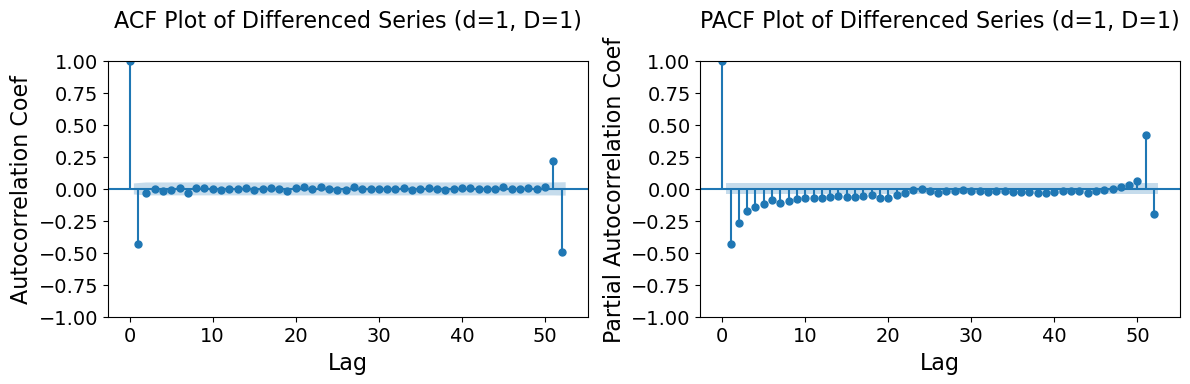

In [32]:
# Test the affect of non-seasonal and seasonal differencing (d=1, D=1)

snsdiffed_series = nsdiffed_series.diff(52).dropna()

# stationarity tests
print('\n[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(snsdiffed_series, 'non-seasonally & seasonally differenced')

# ACF and PACF plots
CH4_train_log_preprocessor.plot_acf_pacf(snsdiffed_series, 'Differenced Series (d=1, D=1)')

**Interpretation of differencing results:**

The CH4 data has a positive trend and repeating annual seasonality, necessitating both non-seasonal and seasonal differencing.  The ACF and PACF plot results inform the SARIMA orders.  A gradual decay of significant spikes in the PACF plot and a single significant spike at lag 1 of the ACF plot indicates an MA(1) process.  The PACF plot suggests an AR order of 1-7.     

- non-seasonal orders (p,d,q) = (1-7,1,0-1)

The seasonal spikes at lags 51 and 52:
- ACF plot suggests seaonal MA(1)
- PACF plot suggests seasonal AR(1)
- seasonal orders (P,D,Q,s) = (0-1,1,0-1,52)

# TimeSeriesSplit CV for validation

leaving this code here for the possible purpose of generating all possible combinations of orders based on input values.  

Focus the model search on the d=1, D=1 ACF/PACF patterns

def get_models_from_acf_pacf():
    '''Generate models based on d=1,D=1 ACF/PACF patterns'''
    models = []
    
    # non-seasonal orders based on PACF decay to lag 7
    for p in [1, 2, 3, 4, 5, 6, 7]:
        # non-seasonal MA based on ACF spike at lag 1
        for q in [0, 1]:
            # seasonal orders based on spikes at 51,52
            for P in [0, 1, 2]:
                for Q in [0, 1]:
                    # skip redundant combinations
                    if not (p == 0 and q == 0):
                        models.append({
                            'order': (p, 1, q),
                            'seasonal_order': (P, 1, Q, 52)
                    })
    return models

informed_models = get_models_from_acf_pacf()
print(f'Generated {len(informed_models)} models for evaluation\n')

models_df = pd.DataFrame(informed_models)
print(models_df)

In [33]:
# Run TimeSeriesSplit on the most recent 15 years of train data

recent_years = 15
recent_cutoff = CH4_train_log_preprocessed.index[-1] - pd.DateOffset(years=recent_years)
CH4_recent = CH4_train_log_preprocessed[CH4_train_log_preprocessed.index >= recent_cutoff]

print(f'CH4_recent first date: {CH4_recent.index[0]}')
print(f'CH4_recent final date: {CH4_recent.index[-1]}')

CH4_recent first date: 2008-10-26 00:00:00
CH4_recent final date: 2023-10-22 00:00:00


In [34]:
def get_models_from_acf_pacf():
    '''strategic model set that captures ACF/PACF patterns'''
    models = []
    
    # Test progressive AR complexity (based on PACF decay pattern), without and with MA term
    ar_progression = [
        {'order': (1,1,0), 'seasonal_order': (1,1,1,52)},
        {'order': (2,1,0), 'seasonal_order': (1,1,1,52)},  
        {'order': (3,1,0), 'seasonal_order': (1,1,1,52)},  # Moderate complexity
        {'order': (4,1,0), 'seasonal_order': (1,1,1,52)},  # Higher AR
        {'order': (5,1,0), 'seasonal_order': (1,1,1,52)},  
        {'order': (6,1,0), 'seasonal_order': (1,1,1,52)},  
        {'order': (7,1,0), 'seasonal_order': (1,1,1,52)},  # Maximum from PACF
    ]
    models.extend(ar_progression)
    
    ar_progression_with_ma = [
        {'order': (1,1,1), 'seasonal_order': (1,1,1,52)},
        {'order': (2,1,1), 'seasonal_order': (1,1,1,52)},  
        {'order': (3,1,1), 'seasonal_order': (1,1,1,52)},  # Moderate complexity
        {'order': (4,1,1), 'seasonal_order': (1,1,1,52)},  # Higher AR
        {'order': (5,1,1), 'seasonal_order': (1,1,1,52)},  
        {'order': (6,1,1), 'seasonal_order': (1,1,1,52)},  
        {'order': (7,1,1), 'seasonal_order': (1,1,1,52)},  # Maximum from PACF
    ]
    models.extend(ar_progression_with_ma)
    
    # Test seasonal variations (based on seasonal spikes)
    seasonal_variations = [
        {'order': (1,1,1), 'seasonal_order': (0,1,0,52)},  # No seasonal AR or MA
        {'order': (1,1,1), 'seasonal_order': (0,1,1,52)},  # No seasonal AR
        {'order': (1,1,1), 'seasonal_order': (1,1,0,52)},  # No seasonal MA
        {'order': (1,1,1), 'seasonal_order': (2,1,1,52)},  # Higher seasonal AR
        {'order': (1,1,1), 'seasonal_order': (1,1,2,52)},  # Higher seasonal MA
        {'order': (1,1,1), 'seasonal_order': (2,1,2,52)},  # Higher seasonal AR and MA
    ]
    models.extend(seasonal_variations)
    
    return models

candidate_models = get_models_from_acf_pacf()
print(f'Generated {len(candidate_models)} candidate models')

Generated 20 candidate models


In [35]:
def evaluate_models_tscv(models_list, data, n_splits=5, test_size=52, gap=13): # 3 month gap between train and validation sets to prevent leakage
    '''Evaluate specified candidate models on validation sets'''

    start_time = time.perf_counter()
    
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    
    print(f'Evaluating {len(models_list)} models with {n_splits} folds each')
    print(f'Total iterations: {len(models_list) * n_splits}\n')

    # Check split sizes
    for i, (train_idx, val_idx) in enumerate(tscv.split(data)):
        print(f'Fold {i+1}: Train={len(train_idx)} ({len(train_idx)/52:.1f} years), '
              f'Val={len(val_idx)} ({len(val_idx)/52:.1f} years), 'f'Total={len(train_idx) + len(val_idx)}')
    print()
    
    results_summary = []
    
    for params in tqdm(models_list, desc='Models'):
        rmse_scores, mae_scores = [], []
        aic_values, bic_values = [], []
        lb_pval_lag1, lb_pval_lag5, lb_pval_lag10, lb_pval_lag52  = [], [], [], []
        seasonal_strengths = []
        
        successful_folds = 0
        
        for train_idx, val_idx in tscv.split(data):
            train_fold = data.iloc[train_idx]
            val_fold = data.iloc[val_idx]
            
            try:
                model = SARIMAX(
                    train_fold, 
                    order=params['order'], 
                    seasonal_order=params['seasonal_order']
                )

                results = model.fit(
                    disp=False, 
                    maxiter=2000,
                    method='powell',
                    enforce_stationarity=True,
                    enforce_invertibility=True
                )
                
                # Check convergence
                converged = results.mle_retvals.get('converged', False)
                if not converged:
                    continue  # Skip non-converged folds
                
                successful_folds += 1
                
                # Forecast and calculate metrics
                forecast = results.get_forecast(steps=len(val_fold))
                forecast_values = forecast.predicted_mean
                
                rmse = np.sqrt(mean_squared_error(val_fold, forecast_values))
                mae = mean_absolute_error(val_fold, forecast_values)

                # Ljung-Box test with safety check
                if len(results.resid) >= 52:
                    lb_test_comprehensive = acorr_ljungbox(results.resid, lags=[1,5,10,52], return_df=True)
                    lb_pval_lag1.append(lb_test_comprehensive.loc[1, 'lb_pvalue'])
                    lb_pval_lag5.append(lb_test_comprehensive.loc[5, 'lb_pvalue'])
                    lb_pval_lag10.append(lb_test_comprehensive.loc[10, 'lb_pvalue'])
                    lb_pval_lag52.append(lb_test_comprehensive.loc[52, 'lb_pvalue'])
                
                rmse_scores.append(rmse)
                mae_scores.append(mae)
                aic_values.append(results.aic)
                bic_values.append(results.bic)
                
                # Seasonal strength
                if len(forecast_values) >= 52:
                    seasonal_strengths.append(np.std(forecast_values))
                    
            except Exception as e:
                # Skip failed folds
                continue
        
        # Only include models with sufficient successful folds
        if successful_folds >= 3:  # At least 3/5 folds converged
            convergence_rate = successful_folds / n_splits
            
            results_summary.append({
                'order': params['order'],
                'seasonal_order': params['seasonal_order'],
                'successful_folds': successful_folds,
                'convergence_rate': convergence_rate,
                'RMSE_mean': np.mean(rmse_scores) if rmse_scores else np.nan,
                'RMSE_std': np.std(rmse_scores) if rmse_scores else np.nan,
                'MAE_mean': np.mean(mae_scores) if mae_scores else np.nan,
                'AIC_mean': np.mean(aic_values) if aic_values else np.nan,
                'BIC_mean': np.mean(bic_values) if bic_values else np.nan,
                'Seasonal_Strength': np.mean(seasonal_strengths) if seasonal_strengths else 0,
                'LB_lag1_pval_mean': np.mean(lb_pval_lag1) if lb_pval_lag1 else np.nan,
                'LB_lag5_pval_mean': np.mean(lb_pval_lag5) if lb_pval_lag5 else np.nan,
                'LB_lag10_pval_mean': np.mean(lb_pval_lag10) if lb_pval_lag10 else np.nan,
                'LB_lag52_pval_mean': np.mean(lb_pval_lag52) if lb_pval_lag52 else np.nan
            })


    # get the total duration and duration per model
    end_time = time.perf_counter()     
    total_duration = end_time - start_time

    print(f'\nTotal duration: {total_duration / 60:.2f} minutes')
    print(f'Average duration per model: {(total_duration / 60) / len(models_list):.2f} minutes')
        
    return pd.DataFrame(results_summary)

# Run the focused evaluation
print('Starting model evaluation...')
candidate_model_results_df = evaluate_models_tscv(
    models_list=candidate_models,
    data=CH4_train_log_preprocessed,
    n_splits=5,       
    test_size=52,
    gap=13
)

sorted_candidate_models_df = candidate_model_results_df.sort_values(by='RMSE_mean')
print('Candidate models for full CH4_train set sorted by RMSE mean')
print(sorted_candidate_models_df)

Starting model evaluation...
Evaluating 20 models with 5 folds each
Total iterations: 100

Fold 1: Train=1839 (35.4 years), Val=52 (1.0 years), Total=1891
Fold 2: Train=1891 (36.4 years), Val=52 (1.0 years), Total=1943
Fold 3: Train=1943 (37.4 years), Val=52 (1.0 years), Total=1995
Fold 4: Train=1995 (38.4 years), Val=52 (1.0 years), Total=2047
Fold 5: Train=2047 (39.4 years), Val=52 (1.0 years), Total=2099



Models: 100%|██████████| 20/20 [12:50:36<00:00, 2311.85s/it]  



Total duration: 770.64 minutes
Average duration per model: 38.53 minutes
Candidate models for full CH4_train set sorted by RMSE mean
        order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
3   (4, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009505   
4   (5, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009520   
2   (3, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009534   
6   (7, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009536   
5   (6, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009542   
1   (2, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009626   
0   (1, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009745   
15  (1, 1, 1)  (0, 1, 1, 52)                 5               1.0   0.010010   
18  (1, 1, 1)  (1, 1, 2, 52)                 5               1.0   0.010038   
7   (1, 1, 1)  (1, 1, 1, 52)                 5               1.0   0.010110 

Important Note:  Powell is the only solver (method) to get good convergence on all models

In [38]:
RMSE_low = 0.009505
RMSE_high = 0.011436
RMSE_std_low = 0.000950
RMSE_std_high = 0.001346

print('=== Model Performance Analysis ===')

# basic RMSE comparison
rmse_range_pct = ((RMSE_high - RMSE_low) / RMSE_low) * 100
print(f'RMSE range: {RMSE_low:.6f} to {RMSE_high:.6f}')
print(f'Best model has {rmse_range_pct:.1f}% lower error than the worst model')

# model stability across folds (cv = coefficient of variation)
cv_best = (RMSE_std_low / RMSE_low) * 100
cv_worst = (RMSE_std_high / RMSE_high) * 100
print(f'\nModel stability (CV = coefficient of variation, lower = more consistent):')
print(f'Best model CV across folds: {cv_best:.1f}%')
print(f'Worst model CV across folds: {cv_worst:.1f}%')

=== Model Performance Analysis ===
RMSE range: 0.009505 to 0.011436
Best model has 20.3% lower error than the worst model

Model stability (CV = coefficient of variation, lower = more consistent):
Best model CV across folds: 10.0%
Worst model CV across folds: 11.8%


I have sorted the model performances based on RMSE, which is the standard deviation of the residuals (prediction errors train vs validation sets)

The model with the lowest mean RMSE has ~20% lower error compared to the model with the highest mean RMSE, which is a moderate difference that may be meaningul. However, the narrow range of error (0.010205 to 0.011192) suggests that all models are performing reasonably well on the 5 fold cross validation sets.  

The RMSE_std reports on the consistency/stability of model performance across different time periods (folds).  Models with a coefficient of variation < 10% are considered to have good stability (>15% may be problematic).  So, even the worst model has reasonably good stability across multiple validation sets.  

Note: seasonal_strength measures how much seasonal variation that the forecast captures.  The magnitude of the values relate to the strength of the seasonal pattern (higher value means greater seasonal pattern).  There is good consistency in the seasonal_strength score across all models indicating that all do a reasonably good jop at detecting seasonal patterns.  But, the low Ljung-Box p values (0 << 0.05) for all models indicate remaining seasonal structure in the residuals.  

The low Ljung-Box mean p values suggest that the seasonal orders (P,Q) may need to be increased to capture more/all of the seasonal patterns.  

In [39]:
# Apply the Pareto Frontier Approach to determine the best model on both RMSE and complexity (BIC)
# BIC is used since it penalizes complexity more so than AIC. 

def select_pareto_optimal_models(results_df, complexity_metric='BIC_mean'):
    '''Find models that are optimal in the RMSE-complexity trade-off'''
    # calculate parameter count as complexity measure
    results_df['param_count'] = (
        results_df['order'].apply(lambda x: x[0] + x[2]) + # p,q
        results_df['seasonal_order'].apply(lambda x: x[0] + x[2]) # P,Q
                                 )
    # find Pareto frontier: models where no other model is better in both RMSE and complexity
    pareto_optimal = []

    for _, candidate in results_df.iterrows():
        dominated = False
        for _, other in results_df.iterrows():
            # check if other model is bettter in both dimensions
            if (other['RMSE_mean'] <= candidate['RMSE_mean'] and
                other[complexity_metric] <= candidate[complexity_metric] and
                (other['RMSE_mean'] < candidate['RMSE_mean'] or 
                 other[complexity_metric] < candidate[complexity_metric])):
                dominated = True
                break
        if not dominated:
            pareto_optimal.append(candidate)

    return pd.DataFrame(pareto_optimal).sort_values('RMSE_mean')

# get Pareto-optimal models
pareto_models = select_pareto_optimal_models(candidate_model_results_df)
print('Pareto-optimal models (RMSE vs BIC):')
print(pareto_models[['order', 'seasonal_order', 'RMSE_mean', 'BIC_mean', 'param_count']])

Pareto-optimal models (RMSE vs BIC):
        order seasonal_order  RMSE_mean      BIC_mean  param_count
3   (4, 1, 0)  (1, 1, 1, 52)   0.009505 -11566.234030            6
4   (5, 1, 0)  (1, 1, 1, 52)   0.009520 -11589.413522            7
6   (7, 1, 0)  (1, 1, 1, 52)   0.009536 -11611.865417            9
15  (1, 1, 1)  (0, 1, 1, 52)   0.010010 -11762.959105            3
8   (2, 1, 1)  (1, 1, 1, 52)   0.010236 -11770.658901            5


# Validate Model Finalists on the Test Set

In [40]:
# extract order and seasonal_order from the Pareto frontier results
final_candidates = [
    {'order': row['order'], 'seasonal_order': row['seasonal_order']}
    for _, row in pareto_models.iterrows()
]

def validate_on_test_set(models_list, train_data, test_data, test_data_original):
    '''Validation of final candidate models on the originally held out test set'''

    validation_test_results = []

    for model_params in models_list:
        model = SARIMAX(train_data,
                        order=model_params['order'],
                        seasonal_order=model_params['seasonal_order'])

        results = model.fit(method='powell', disp=False)

        # forecast on the test set
        forecast = results.get_forecast(steps=len(test_data))
        forecast_values = forecast.predicted_mean

        # calculate metrics
        rmse_test = np.sqrt(mean_squared_error(test_data, forecast_values))
        mae_test = mean_absolute_error(test_data, forecast_values)

        # convert final forecasts to original units for interpretation
        forecast_original = np.exp(forecast_values)

        validation_test_results.append({
            'order': model_params['order'],
            'seasonal_order': model_params['seasonal_order'],
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'rmse_test_original': np.sqrt(mean_squared_error(test_data_original, forecast_original)),
            'mae_test_original': mean_absolute_error(test_data_original, forecast_original)
        })

    validation_test_results_df = pd.DataFrame(validation_test_results)
    return validation_test_results_df.sort_values(by='rmse_test')

start_time = time.perf_counter()

test_performance = validate_on_test_set(final_candidates,
                                        CH4_train_log_preprocessed,
                                        CH4_test_log_preprocessed,
                                        CH4_test_preprocessed)

end_time = time.perf_counter()
elapsed_time = end_time - start_time

print('Evaluation metrics for final candidate models')
print('-' * 45)
print(f'Elapsed time: {elapsed_time/60:.2f} minutes\n')
print(test_performance)

Evaluation metrics for final candidate models
---------------------------------------------
Elapsed time: 28.47 minutes

       order seasonal_order  rmse_test  mae_test  rmse_test_original  \
2  (7, 1, 0)  (1, 1, 1, 52)   0.004636  0.003592            8.983181   
1  (5, 1, 0)  (1, 1, 1, 52)   0.004860  0.003523            9.411591   
3  (1, 1, 1)  (0, 1, 1, 52)   0.005097  0.003489            9.868525   
4  (2, 1, 1)  (1, 1, 1, 52)   0.005098  0.003474            9.870663   
0  (4, 1, 0)  (1, 1, 1, 52)   0.005108  0.003570            9.891836   

   mae_test_original  
2           6.971737  
1           6.836281  
3           6.768671  
4           6.739167  
0           6.927335  


In [42]:
# I will compare the top Pareto frontier model, which is also the most complex, with the most simple model
# and the lowest peforming model since it was the highest performing model on the train set.

CH4_test_mean = CH4_test_preprocessed.mean()
print(f'CH4_test mean: {CH4_test_mean:.2f} ppb')
print(f'The (7,1,0)(1,1,1,52) model error is {(8.983181/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')
print(f'The (1,1,1)(0,1,1,52) model error is {(9.868525/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')
print(f'The (4,1,0)(0,1,1,52) model error is {(9.891836/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')

CH4_test mean: 1943.87 ppb
The (7,1,0)(1,1,1,52) model error is 0.46% of the mean CH4 test data
The (1,1,1)(0,1,1,52) model error is 0.51% of the mean CH4 test data
The (4,1,0)(0,1,1,52) model error is 0.51% of the mean CH4 test data


**Interpretation of candidate model results**

error relative to test set data mean:
  - (7,1,0)(1,1,1,52) - 0.46%
  - (1,1,1)(0,1,1,52) - 0.51%
  - (4,1,0)(1,1,1,52) - 0.51%

All three models should be considered for the next round of evaluation.  The most complex model has 7 non-seasonal AR terms, which is consisted with the differecing analysis ACF/PACF plots.  The simplest model is minimally lesser by only 0.05% RMSE and may generalize better for forecasting.  The (4,1,0)(1,1,1,52) model has similar performance to the other two models based on RMSE, performed the best on the in-sample fit, and represents the middle ground of complexity.  

# Evaluate best model in-sample residuals

In [45]:
# Evaluate SARIMA(7,1,0)(1,1,1,52)

sarima710111 = in_sample_residual_analys(
    CH4_train_log_preprocessed,
    'order': (7,1,0),
    'seasonal_order': (1,1,1,52),
)

SyntaxError: invalid syntax (2472495627.py, line 5)

# Evaluate Residuals of Best Model Predictions vs the Test Set

=== Residual Analysis for Best Model (7,1,0)(1,1,1,52) ===
Test Residuals - Mean: -0.000011, Std: 0.004666
Skewness: -1.022, Kurtosis: 0.159
Shapiro-Wilk normality test: p-value = 0.0000
Ljung-Box p-values:
  Lag 1: 0.0000 ***
  Lag 5: 0.0000 ***
  Lag 10: 0.0000 ***
  Lag 52: 0.0000 ***

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


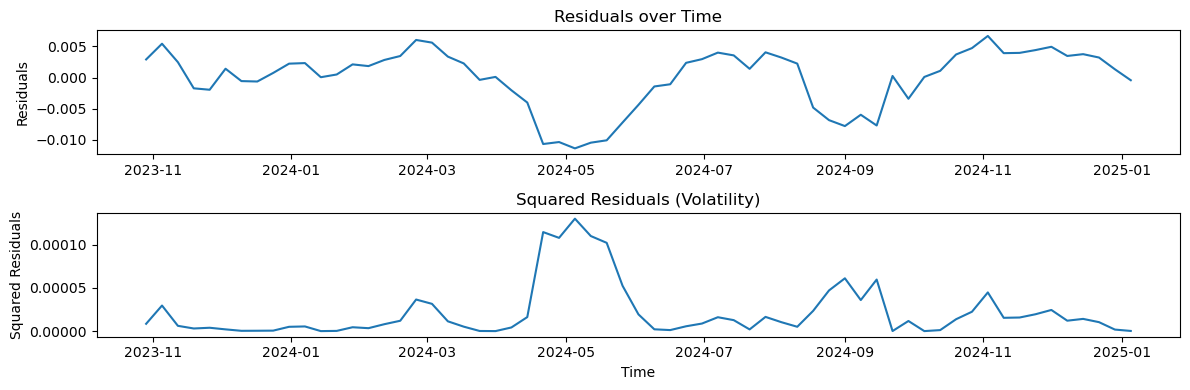

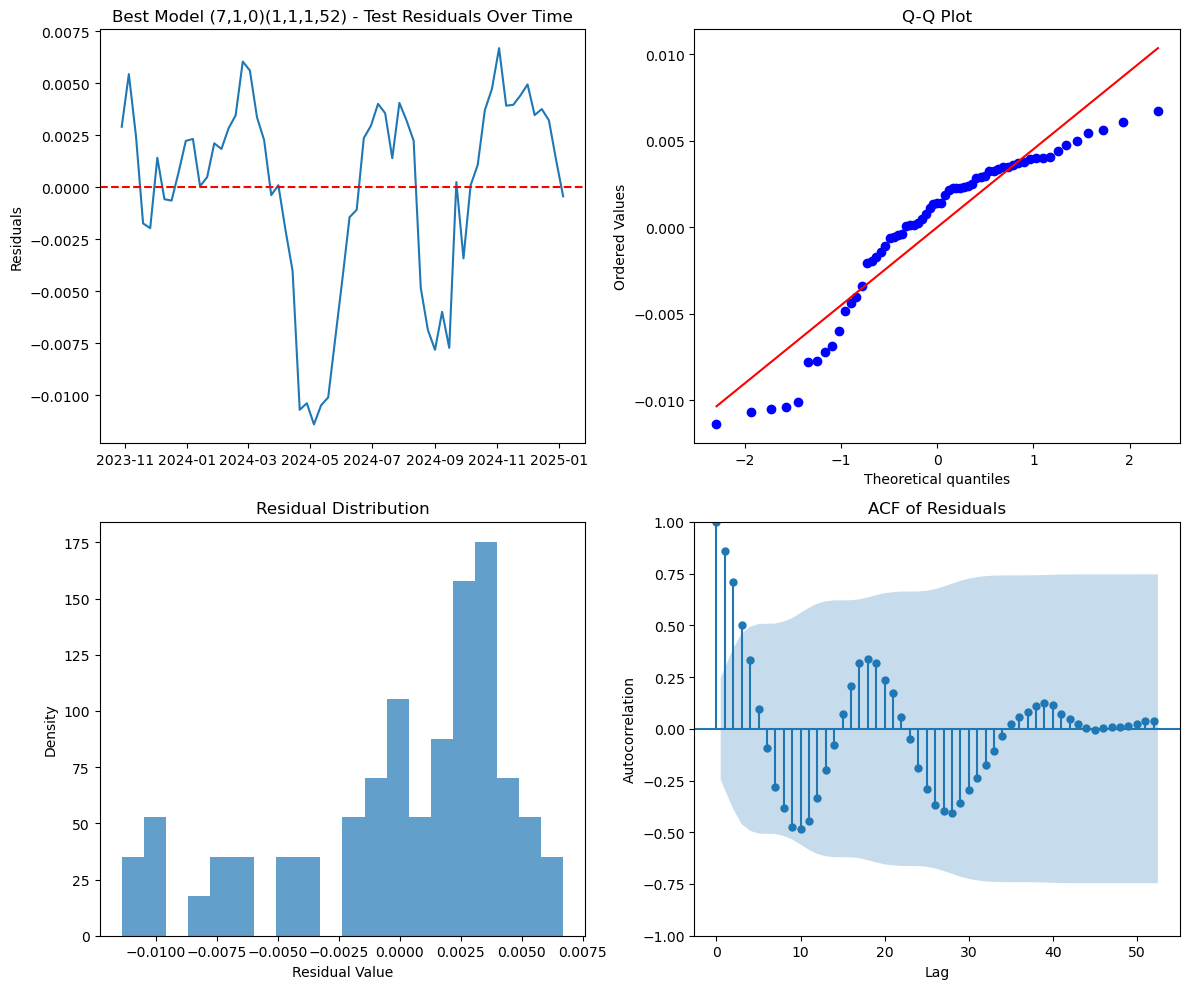

In [131]:
# Evaluate SARIMA(7,1,0)(1,1,1,52)

residuals_best, results_best = comprehensive_residual_analysis(
    {'order': (7,1,0), 'seasonal_order': (1,1,1,52)},
    CH4_train_log_preprocessed,
    CH4_test_log_preprocessed,
    'Best Model (7,1,0)(1,1,1,52)'
)

=== Residual Analysis for Best Model (1,1,1)(0,1,1,52) ===
Test Residuals - Mean: -0.002160, Std: 0.004589
Skewness: -1.054, Kurtosis: 0.226
Shapiro-Wilk normality test: p-value = 0.0000
Ljung-Box p-values:
  Lag 1: 0.0000 ***
  Lag 5: 0.0000 ***
  Lag 10: 0.0000 ***
  Lag 52: 0.0000 ***

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


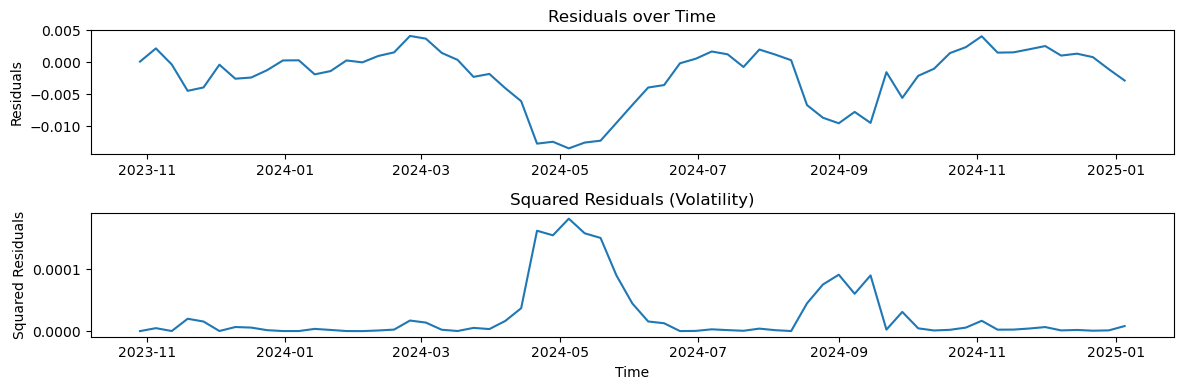

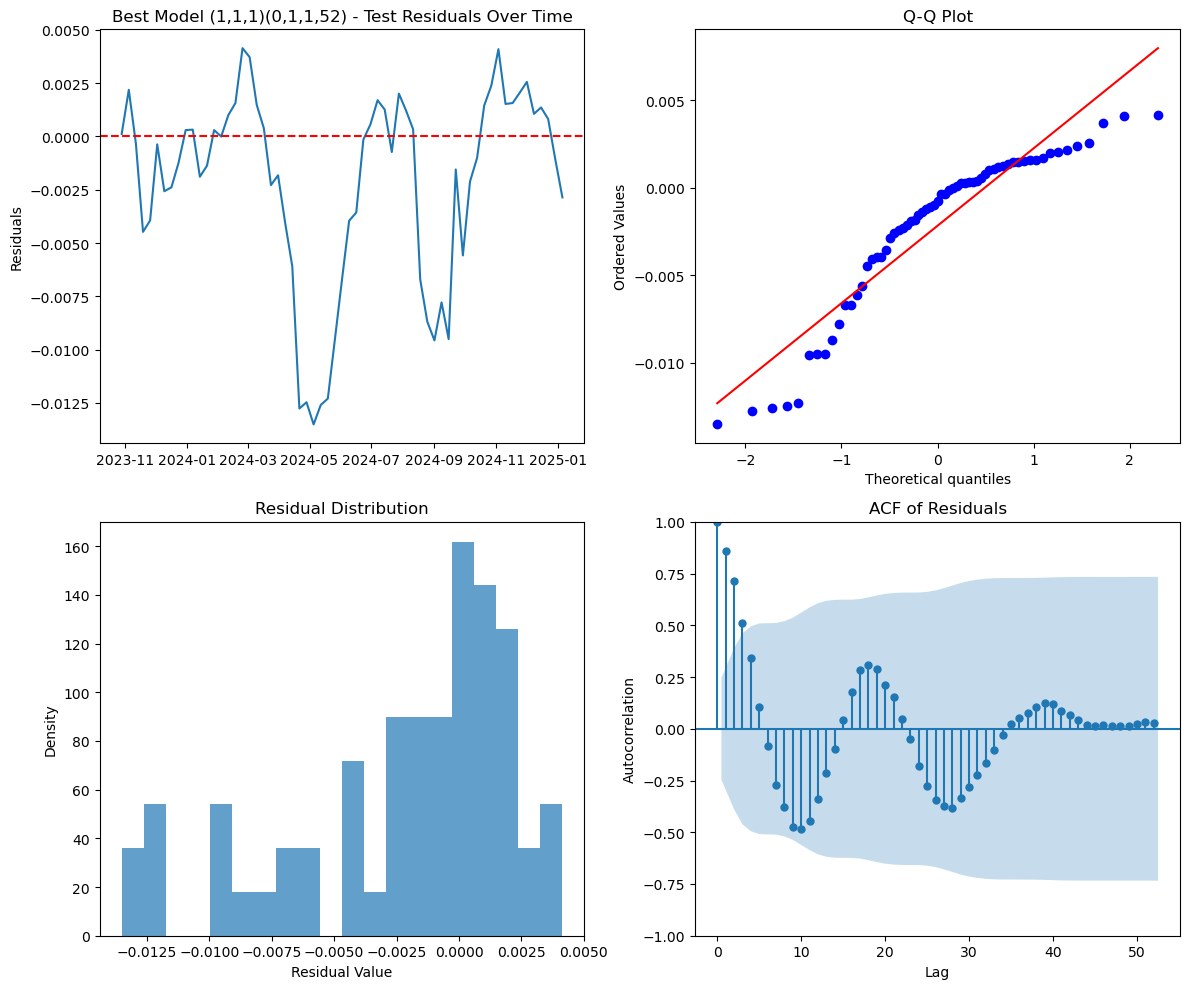

In [132]:
# Evaluate SARIMA(1,1,1)(0,1,1,52)

residuals_best, results_best = comprehensive_residual_analysis(
    {'order': (1,1,1), 'seasonal_order': (0,1,1,52)},
    CH4_train_log_preprocessed,
    CH4_test_log_preprocessed,
    'Best Model (1,1,1)(0,1,1,52)'
)

=== Residual Analysis for Best Model (7,1,1)(2,1,2,52) ===
Test Residuals - Mean: -0.002048, Std: 0.004604
Skewness: -1.055, Kurtosis: 0.215
Shapiro-Wilk normality test: p-value = 0.0000
Ljung-Box p-values:
  Lag 1: 0.0000 ***
  Lag 5: 0.0000 ***
  Lag 10: 0.0000 ***
  Lag 52: 0.0000 ***

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


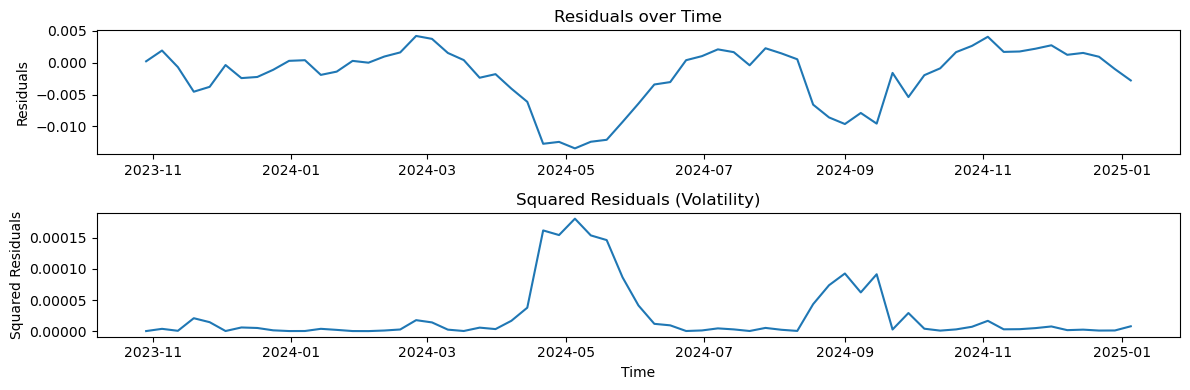

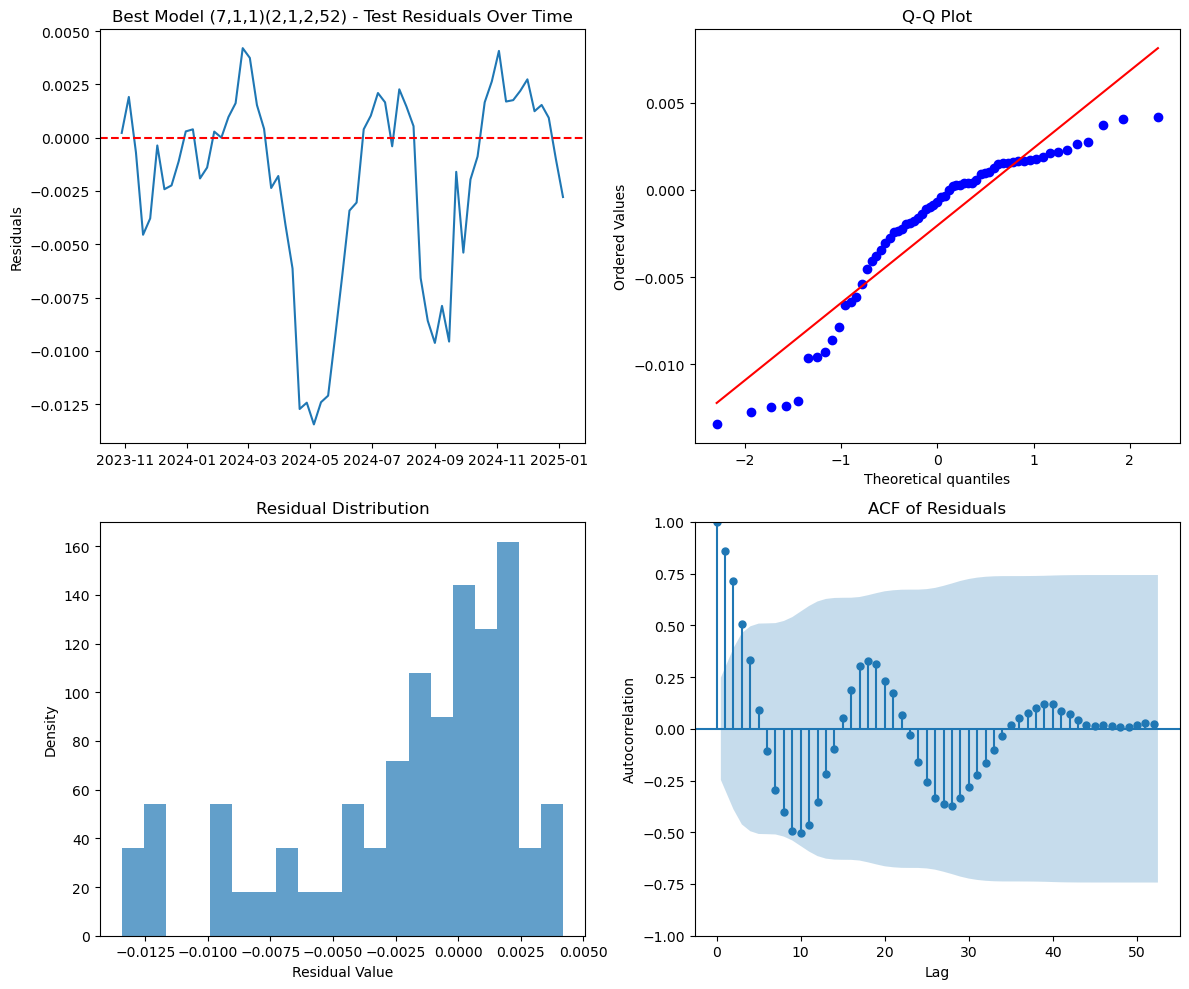

In [135]:
# Evaluate SARIMA(7,1,1)(1,1,1,52)

residuals_best, results_best = comprehensive_residual_analysis(
    {'order': (7,1,1), 'seasonal_order': (2,1,2,52)},
    CH4_train_log_preprocessed,
    CH4_test_log_preprocessed,
    'Best Model (7,1,1)(2,1,2,52)'
)

In [136]:
# Check if your TimeSeriesSplit used the same preprocessing as final test
print("TimeSeriesSplit data shape:", CH4_recent.shape)
print("Final train data shape:", CH4_train_log_preprocessed.shape)
print("Final test data shape:", CH4_test_log_preprocessed.shape)

# Were they from the same time period?
print("TimeSeriesSplit period:", CH4_recent.index[0], "to", CH4_recent.index[-1])
print("Train period:", CH4_train_log_preprocessed.index[0], "to", CH4_train_log_preprocessed.index[-1])
print("Test period:", CH4_test_log_preprocessed.index[0], "to", CH4_test_log_preprocessed.index[-1])

TimeSeriesSplit data shape: (783,)
Final train data shape: (2112,)
Final test data shape: (63,)
TimeSeriesSplit period: 2008-10-26 00:00:00 to 2023-10-22 00:00:00
Train period: 1983-05-08 00:00:00 to 2023-10-22 00:00:00
Test period: 2023-10-29 00:00:00 to 2025-01-05 00:00:00


In [137]:
# Check if the same transformation was applied
print("TimeSeriesSplit data stats:")
print(f"  Mean: {CH4_recent.mean()}, Std: {CH4_recent.std()}")
print("Final train stats:")
print(f"  Mean: {CH4_train_log_preprocessed.mean()}, Std: {CH4_train_log_preprocessed.std()}")

TimeSeriesSplit data stats:
  Mean: 7.528362420468365, Std: 0.022666131639718284
Final train stats:
  Mean: 7.489059632226322, Std: 0.04033306182442773


In [139]:
# Check if test period is easier
print(f"Test period characteristics:")
test_volatility = CH4_test_log_preprocessed.diff().std()
train_volatility = CH4_train_log_preprocessed.diff().std()
print(f"Test volatility: {test_volatility:.6f}")
print(f"Train volatility: {train_volatility:.6f}")
print(f"Ratio: {test_volatility/train_volatility:.3f}")

Test period characteristics:
Test volatility: 0.002258
Train volatility: 0.012096
Ratio: 0.187


# Save Best Model Parameters for Production

In [123]:
import json
from datetime import datetime

model_config_best = {
    'model_type': 'SARIMAX',
    'order': (7,1,0),
    'seasonal_order': (1,1,1,52),
    'trend': 'c',
    'enforce_stationarity': True,
    'enforce_invertibility': True,
    'training_data_range': {
        'start': CH4_train_log_preprocessed.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_log_preprocessed.index[-1].strftime('%Y-%m-%d')
    },
    'data_points': len(CH4_train_log_preprocessed),
    'data_frequency': 'W',  # Weekly
    'transformation': 'log',  # using log-transformed data
    'preprocessor_version': '1.0',  
    'cv_performance': {  # Store best CV metrics
        'RMSE_mean': 0.010205,
        'MAE_mean': 0.007906
    },
    'test_performance': {  # From final validation
        'RMSE_log': 0.004636,
        'MAE_log': 0.003592,
        'RMSE_original': 8.983181,
        'MAE_original': 6.971737
    },
    'selection_rationale': 'Best overall RMSE in both CV and test validation',
    'fit_method': 'powell',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

model_config_best_simple = {
    'model_type': 'SARIMAX',
    'order': (1,1,1),
    'seasonal_order': (0,1,1,52),
    'trend': 'c',
    'enforce_stationarity': True,
    'enforce_invertibility': True,
    'training_data_range': {
        'start': CH4_train_log_preprocessed.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_log_preprocessed.index[-1].strftime('%Y-%m-%d')
    },
    'data_points': len(CH4_train_log_preprocessed),
    'data_frequency': 'W',  # Weekly
    'transformation': 'log',  # using log-transformed data
    'preprocessor_version': '1.0',  
    'cv_performance': {  # Store best CV metrics
        'RMSE_mean': 0.010530,
        'MAE_mean': 0.008095
    },
    'test_performance': {
        'RMSE_log': 0.005097,
        'MAE_log': 0.003489,
        'RMSE_original': 9.868525,
        'MAE_original': 6.768671
    },
    'selection_rationale': 'Pareto-optimal balance of simplicity and performance',
    'fit_method': 'powell',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# save as JSON file
with open('../results/CH4_train_best_model_config.json', 'w') as f:
    json.dump(model_config_best, f, indent=2)

with open('../results/CH4_train_best_simple_model_config.json', 'w') as f:
    json.dump(model_config_best_simple, f, indent=2)

print('CH4 best model configuration saved.  Re-fit in next notebook.')
print('CH4 best simple model configuration saved.  Re-fit in next notebook.')

CH4 best model configuration saved.  Re-fit in next notebook.
CH4 best simple model configuration saved.  Re-fit in next notebook.


**NOTE** 
- Check deepseek regarding saving the models for the entire dataset, not just the train set
- may want to produce the plots and analyze residuals of prediction vs test set in this notebook and treat the next notebook as just forecasting.  